Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i tempo na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



In [1]:
import os
from pathlib import Path
import re
import pandas as pd

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# klient do Digital Ocean

import boto3

s3 = boto3.client("s3")

BUCKET_NAME = "wk1"
REMOTE_DATA = 'zadanie_9/'

In [4]:
LOCAL_DATA = Path('data')

os.makedirs(LOCAL_DATA / 'raw', exist_ok=True)

In [5]:
# pobranie plików z Digital Ocean
# pliki zostały tam grane ręcznie z interface Digital Ocean

def s3_download(csv, year):
    s3.download_file(Bucket=BUCKET_NAME, Key=REMOTE_DATA + 'raw/' + csv, Filename=LOCAL_DATA / 'raw' / csv)
    df = pd.read_csv(LOCAL_DATA / 'raw' / csv, sep=';')
    df['year'] = year
    return df

df_2023 = s3_download('halfmarathon_wroclaw_2023__final.csv', 2023)
df_2024 = s3_download('halfmarathon_wroclaw_2024__final.csv', 2024)

In [6]:
# porównanie nazw kolumn

print(df_2023.columns == df_2024.columns)

# połączenie DataFrame'ów w jeden

df_full = pd.concat([df_2023, df_2024], ignore_index=True)
df_full.shape

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


(21957, 28)

In [7]:
df_full.sample(10)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,year
6035,6036.0,7646,MONIKA,MACHNIKOWSKA,WARSZAWA,POL,NaN,K,1322.0,K30,...,01:31:30,5961.0,6.376667,02:07:23,6025.0,7.176667,0.084867,02:13:53,6.346686,2023
5438,5439.0,273,DAMIAN,TYLKOWSKI,WROCŁAW,POL,NaN,M,4365.0,M30,...,01:28:44,5411.0,6.050000,02:02:41,5404.0,6.790000,0.062467,02:08:59,6.114403,2023
14847,5898.0,4398,MONIKA,KARPIŃSKA-GROMEK,WARSZAWA,POL,KS LEMIESZ TEAM,K,1076.0,K40,...,01:27:50,6052.0,6.000000,01:59:08,5949.0,6.260000,0.032000,02:05:57,5.970609,2024
20798,NaN,24901,MICHAŁ,NOWAK,NaN,NaN,Darłowo,M,NaN,M30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
21338,NaN,24707,JAKUB,STAŃCZYK,NaN,NaN,NaN,M,NaN,M40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
8004,8005.0,145,ANDRZEJ,PERCZAK,WROCŁAW,POL,NaN,M,5757.0,M20,...,01:57:02,8045.0,8.266667,02:44:23,8030.0,9.470000,0.131933,02:51:42,8.139370,2023
5800,5801.0,4439,GRZEGORZ,DRZEWIECKI,TUŁOWICE,POL,TRT TUŁOWICE,M,4586.0,M40,...,01:33:20,6261.0,6.363333,02:06:20,5877.0,6.600000,0.028933,02:11:59,6.256617,2023
10232,1283.0,1920,MICHAŁ,KOŁODZIEJSKI,KROTOSZYN,POL,NaN,M,1197.0,M20,...,01:12:55,1636.0,4.863333,01:36:47,1347.0,4.773333,-0.007000,01:41:48,4.825788,2024
1929,1930.0,1687,MARCIN,ZBYTNIEWSKI,WARSZAWA,POL,NaN,M,1759.0,M20,...,01:16:06,2301.0,5.096667,01:43:01,1990.0,5.383333,0.015800,01:47:39,5.103105,2023
499,500.0,5729,MATEO,ORONA,NaN,POL,NaN,M,469.0,M20,...,01:01:12,220.0,4.336667,01:29:01,473.0,5.563333,0.104867,01:33:51,4.448922,2023


In [8]:
# usunięcie kolumn nieistonych i tych, które zostały wyliczone na podstawie innych kolumn

df = df_full[['Płeć', 'Kategoria wiekowa', 'Rocznik', 'year', '5 km Czas', 'Czas']]
df.sample(10)

,Płeć,Kategoria wiekowa,Rocznik,year,5 km Czas,Czas
19283,K,K40,1975.0,2024,NaN,NaN
6654,M,M30,1989.0,2023,00:30:31,02:20:49
7650,K,K20,NaN,2023,00:36:44,02:36:25
12066,K,K20,1995.0,2024,00:26:31,01:53:06
8809,K,K30,1991.0,2023,NaN,DNS
21130,M,M40,1977.0,2024,NaN,NaN
13553,M,M40,NaN,2024,00:29:01,01:59:28
18280,K,K20,1998.0,2024,00:33:14,02:32:10
12107,M,M30,1989.0,2024,00:26:00,01:53:21
12226,M,M20,1998.0,2024,00:28:12,01:53:55


In [9]:
# Jakie wartości są w kolumnie Czas

def istime(x):
    return (type(x) is str) and (re.search('\d\d\:\d\d\:\d\d', x) != None)

def dist_time(df, col):
    dist = {}
    for x in df[col]:
        if istime(x):
            x = '??:??:??'
        dist[x] = (dist[x] if x in dist else 0) + 1
    return dist

for col in ['5 km Czas', 'Czas']:
    print(f"distinct {col} {dist_time(df, col)}")

distinct 5 km Czas {'??:??:??': 18411, nan: 3546}
distinct Czas {'??:??:??': 18450, 'DNS': 1332, 'DNF': 120, nan: 2055}


In [10]:
# Pozostawienie wierszy, które mają poprawny *Czas

#df = df[df['Czas'].apply(istime)]
df = df[df['5 km Czas'].apply(istime) & df['Czas'].apply(istime)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18411 entries, 0 to 19249
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               18411 non-null  object 
 1   Kategoria wiekowa  18393 non-null  object 
 2   Rocznik            17927 non-null  float64
 3   year               18411 non-null  int64  
 4   5 km Czas          18411 non-null  object 
 5   Czas               18411 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1006.9+ KB


In [11]:
print("Procent pozostałych danych:", round((len(df) / len(df_full)) * 100, 2), "%")

Procent pozostałych danych: 83.85 %


In [12]:
# Zamiana wartości kolumn *Czas ??:??:?? na x(sec)

def convert_time_to_seconds(time):
    try:
        h, m, s = map(int, time.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return time

df['5_km_sec'] = df['5 km Czas'].apply(convert_time_to_seconds)
df['finish_sec'] = df['Czas'].apply(convert_time_to_seconds)

df.drop(columns=['5 km Czas', 'Czas'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18411 entries, 0 to 19249
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               18411 non-null  object 
 1   Kategoria wiekowa  18393 non-null  object 
 2   Rocznik            17927 non-null  float64
 3   year               18411 non-null  int64  
 4   5_km_sec           18411 non-null  int64  
 5   finish_sec         18411 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1006.9+ KB


In [13]:
df['Rocznik'].isna().sum()

484

In [14]:
import numpy as np

df['Rocznik'].replace(0.0, np.NaN, inplace=True)
df['Rocznik'].isna().sum()

502

In [16]:
# tworzymy kolumnę Wiek

import random

def towiek(row):
    x = row['Rocznik']
    if ~np.isnan(x):
        return row['year'] - x
    else:
        x = row['Kategoria wiekowa']
        if type(x) is str:
            rx = re.search('[K|M](\d)0', x)
            if rx:
                return int(rx.group(1)) * 10 + random.randrange(0, 10)
        return None



df['age'] = df.apply(towiek, axis=1)
#df.groupby(wiek).size()
df['age'].value_counts().sort_index()


age
17.0      3
18.0     32
19.0     80
20.0    125
21.0    173
       ... 
76.0      4
77.0      5
79.0      2
80.0      2
89.0      1
Name: count, Length: 64, dtype: int64

In [17]:
df[df['age'].isna()]

,Płeć,Kategoria wiekowa,Rocznik,year,5_km_sec,finish_sec,age
243,M,NaN,NaN,2023,1260,5308,NaN
245,M,NaN,NaN,2023,1228,5310,NaN
845,M,NaN,NaN,2023,1314,5936,NaN
1262,M,NaN,NaN,2023,1505,6178,NaN
2165,M,NaN,NaN,2023,1555,6547,NaN
4795,M,NaN,NaN,2023,1727,7467,NaN
6336,M,NaN,NaN,2023,1766,8221,NaN
8018,M,NaN,NaN,2023,2191,10348,NaN
8066,M,NaN,NaN,2023,2333,10555,NaN
11229,M,NaN,NaN,2024,1566,6509,NaN


In [18]:
df['age'].isna().sum()

18

In [19]:
# jeśli nie udało się uzupełnić kolumny Wiek to wiersze odrzucamy

df.dropna(subset=['age'], inplace=True)
df['age'] = df['age'].astype('int32')

print("Procent pozostałych danych:", round((len(df) / len(df_full)) * 100, 2), "%")

Procent pozostałych danych: 83.77 %


In [20]:
# kolumny Kategoria wiekowa, Rocznik i year usuwamy

df.drop(columns=['Kategoria wiekowa', 'Rocznik', 'year'], inplace=True)
df.sample(10)

,Płeć,5_km_sec,finish_sec,age
4634,M,1736,7407,36
6307,M,1641,8198,27
3381,M,1628,6993,42
2473,M,1393,6647,36
16408,M,1629,8098,25
14195,M,1478,7341,35
7402,K,2058,9107,35
6297,K,1802,8194,50
13476,M,1737,7153,35
14546,K,1684,7464,30


In [21]:
# zmieniamy Płeć K/M na gender F/M

df['gender'] = df['Płeć'].map({'K': 'F', 'M': 'M'})
df.drop(columns=['Płeć'], inplace=True)

df.sample(5)

,5_km_sec,finish_sec,age,gender
12674,1666,6952,25,F
4954,1645,7523,44,M
15138,1888,7648,38,F
14017,1659,7278,55,M
5527,1777,7782,50,F


/tmp/ipykernel_17441/3315937330.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


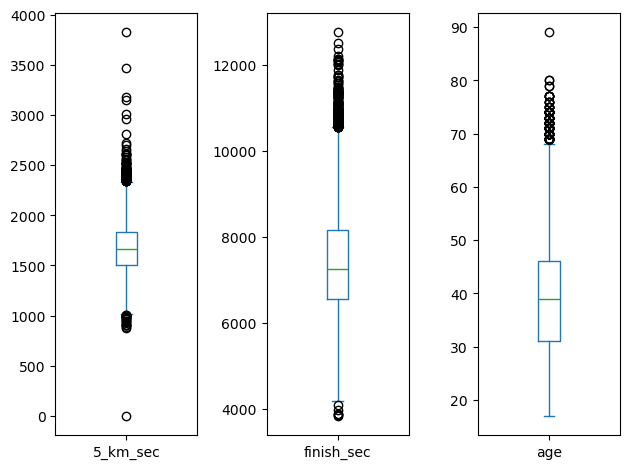

In [22]:
# sprawdzenie wartości odstających

import matplotlib.pyplot as plt

def plotbars(df):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    df['5_km_sec'].plot(ax=axes[0], kind='box')
    df['finish_sec'].plot(ax=axes[1], kind='box')
    df['age'].plot(ax=axes[2], kind='box')
    fig.tight_layout()
    fig.show()

plotbars(df)

/tmp/ipykernel_17441/3315937330.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


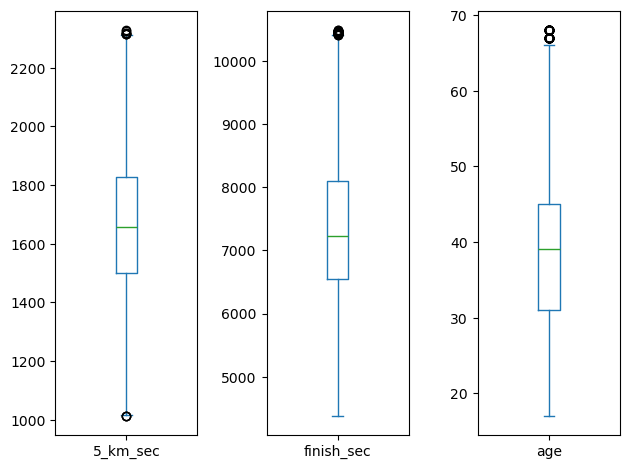

In [23]:
# usunięcie wartości odstających

for column in ['5_km_sec', 'finish_sec', 'age']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[~((df[column] < lower_bound) | (df[column] > upper_bound))]

plotbars(df)

In [24]:
print("Procent pozostałych danych:", round((len(df) / len(df_full)) * 100, 2), "%")

Procent pozostałych danych: 81.91 %


In [25]:
# zapisujemy plik lokalnie

cleaned_csv = 'time_sec_cleaned.csv'

os.makedirs(LOCAL_DATA / 'proc', exist_ok=True)
df.to_csv(LOCAL_DATA / 'proc' / cleaned_csv, index=False, sep=";")

# zapisujemy do Digital Ocean

s3.upload_file(Filename=LOCAL_DATA / 'proc' / cleaned_csv, Bucket=BUCKET_NAME, Key=REMOTE_DATA + 'proc/' + cleaned_csv )